# **CNN+BLSTM MODEL**

**IMPORT MODULES**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from nltk import word_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOAD DATASET**

In [ ]:
data=pd.read_csv('sp_translated.csv')

In [ ]:
data

,Unnamed: 0,Fake,final_clean
0,0,0,intentar prender fuego espós ilesa gravemente ...
1,1,0,ese ser renaud vuelta escenario octubre acción...
2,2,0,traje rojo qué mensaje querer enviar hillary c...
3,3,0,footligar resultado octava jornada h octubre m...
4,4,0,suscríbete podcast poder suscribir él descarga...
...,...,...,...
5995,2966,0,consejo gobierno haber dar visto bueno convoca...
5996,2967,0,investigador valenciano haber desarrollar inno...
5997,2968,0,arrestado actuar coche establecimiento policia...
5998,2969,0,rey haber encargar miercol pedro sanchez prese...


In [ ]:
data['Fake'].value_counts()

1    3000
0    3000
Name: Fake, dtype: int64

In [ ]:
docs = data.final_clean.values
labels = data.Fake.values

In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 3000, 1: 3000})

**TOKENIZATION**

In [ ]:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1  # I add one because it starts counting from 0

In [ ]:
import nltk  # don't forget to do this step everytime in colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['Text_tokenised'] = data['final_clean'].apply(word_tokenize)

In [ ]:
data.head()

,Unnamed: 0,Fake,final_clean,Text_tokenised
0,0,0,intentar prender fuego espós ilesa gravemente ...,"[intentar, prender, fuego, espós, ilesa, grave..."
1,1,0,ese ser renaud vuelta escenario octubre acción...,"[ese, ser, renaud, vuelta, escenario, octubre,..."
2,2,0,traje rojo qué mensaje querer enviar hillary c...,"[traje, rojo, qué, mensaje, querer, enviar, hi..."
3,3,0,footligar resultado octava jornada h octubre m...,"[footligar, resultado, octava, jornada, h, oct..."
4,4,0,suscríbete podcast poder suscribir él descarga...,"[suscríbete, podcast, poder, suscribir, él, de..."


In [ ]:
data['length'] = data['Text_tokenised'].str.len()

In [ ]:
maxlen = data['length'].max()

In [ ]:
maxlen

2806

**SPLIT DATA INTO TRAIN AND VALIDATE SETS**

In [ ]:
# divide the data into train/validate

from sklearn.model_selection import train_test_split


sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    docs, labels, test_size=0.2, random_state=1000)

In [ ]:
Counter(labels)

Counter({0: 3000, 1: 3000})

**CONVERT TEXTS TO SEQUENCES**

In [ ]:
# use keras tokenizer to turn train and valid to sequence


X_train = t.texts_to_sequences(sentences_train)
X_valid = t.texts_to_sequences(sentences_valid)


print(sentences_train[2])
print(X_train[2])

vei ois grito pues ser africo ser coloniaalemania mujer haber ser violar individuo violacion perpetrado manada inmigrante europa contar millon ocultar cifra real ocultar v
[53656, 53657, 2093, 446, 1, 14752, 1, 29839, 39, 2, 1, 1631, 2980, 3466, 13804, 9235, 757, 230, 98, 215, 1773, 1225, 223, 1773, 4553]


**APPLY POST-PADDING**

In [ ]:
# pad the short sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(X_train[1, :])

[ 2153 20089   138 ...     0     0     0]


**EMBEDDING MATRIX**

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

**LOAD PRE-TRAINED WORD EMBEDDINGS**

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
        '/content/drive/MyDrive/thesiss/embeddings-l-model.vec',
        t.word_index, embedding_dim)

In [ ]:
# how many of the embedding vectors are nonzero

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7302208295477722

# **MODEL: CNN + BLSTM**

**BUILD THE MODEL**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam,SGD

def create_model(vocab_size,embedding_dim,maxlen):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
        tf.keras.layers.Dropout(0.1),  
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
 
    adam=Adam(learning_rate=0.001) 
    model.compile(optimizer=adam, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
slice_size = [1000, 2000, 3000, 4000, 5000, 6000]

accuracies = []

for n_samples in slice_size:
    
    X_train_red=X_train[:n_samples]
    y_train_red=y_train[:n_samples]
    model=create_model(vocab_size,embedding_dim,maxlen)
    print('Number of samples: ',n_samples)
    history = model.fit(X_train_red, y_train_red,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=32)

   
    loss, acc = model.evaluate(X_valid, y_valid)
    accuracies.append(round(acc, 3))
    


Number of samples:  1000
Epoch 1/5
32/32 [==============================] - 12s 214ms/step - loss: 0.6921 - accuracy: 0.5290 - val_loss: 0.6840 - val_accuracy: 0.6067
Epoch 2/5
32/32 [==============================] - 6s 179ms/step - loss: 0.5762 - accuracy: 0.7860 - val_loss: 0.4591 - val_accuracy: 0.8058
Epoch 3/5
32/32 [==============================] - 6s 182ms/step - loss: 0.1504 - accuracy: 0.9690 - val_loss: 0.5210 - val_accuracy: 0.8217
Epoch 4/5
32/32 [==============================] - 6s 180ms/step - loss: 0.0432 - accuracy: 0.9930 - val_loss: 0.8313 - val_accuracy: 0.7958
Epoch 5/5
38/38 [==============================] - 2s 51ms/step - loss: 0.7419 - accuracy: 0.7942
Number of samples:  2000
Epoch 1/5
63/63 [==============================] - 16s 178ms/step - loss: 0.6425 - accuracy: 0.5965 - val_loss: 0.4835 - val_accuracy: 0.7700
Epoch 2/5
63/63 [==============================] - 9s 148ms/step - loss: 0.3258 - accuracy: 0.8630 - val_loss: 0.4447 - val_accuracy: 0.7917
Epoc

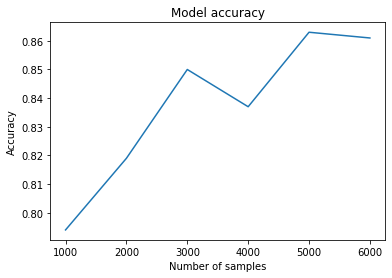

In [ ]:
import matplotlib.pyplot as plt
plt.plot(slice_size,accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of samples')
plt.show()